# 4. Gyakorlat: Döntési fák

In [1]:
import dtreeviz
import warnings
import pydotplus # conda install pydotplus
import numpy as np 
import pandas as pd
from sklearn import tree
from dtreeviz.trees import *
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import recall_score
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
cm = 'viridis' # a diagramok színei globális változó

## Segédfüggvények
Adatok ábrázolásához segédfüggvény: ponthálóvá alakítás

In [2]:
def get_grid(data):
    x_min, x_max = data.iloc[:, 0].min() - 1, data.iloc[:, 0].max() + 1
    y_min, y_max = data.iloc[:, 1].min() - 1, data.iloc[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

Modell ábrázolásához segéd metódus

In [3]:
def scatter_grid(X, y, features, clf_tree, title=None):
    xx, yy = get_grid(X[features])
    predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    le = preprocessing.LabelEncoder()
    
    for i in range(len(predicted)):
        predicted[i] = le.fit_transform(predicted[i])
    
    predicted = predicted.astype(np.float64)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    if title: 
        plt.title(title)
    ax.pcolormesh(xx, yy, predicted, cmap=cm)
    plt.scatter(
        X.iloc[:, 0], 
        X.iloc[:, 1], 
        c=le.fit_transform(y), 
        s=100, 
        cmap=cm, 
        edgecolors='black', 
        linewidth=1.5
    )
    plt.show()

A döntési fa ábrázolásához metódus

In [4]:
def tree_graph_to_png(dtree, feature_names, figs, fonts):
    plt.figure(figsize=figs)
    tree.plot_tree(dtree, filled=True, rounded=True, feature_names = feature_names, fontsize=fonts)
    plt.show()

## Adatok beolvasása

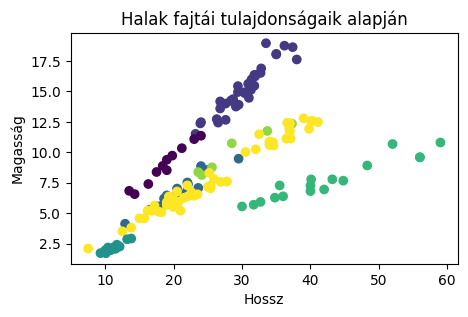

In [5]:
df = pd.read_csv('halak.csv', header=0, sep=';', encoding='ISO-8859-2')

X = df[['Hossz1', 'Magassag']] # Független változók
Y = df['Faj'] # Célváltozó

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)  # Szétválasztás tanító-teszt adatokra

le = preprocessing.LabelEncoder() # Címkekódoló a fajták számmal való reprezentálásához

plt.figure(figsize=(5, 3))
plt.title("Halak fajtái tulajdonságaik alapján")
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=le.fit_transform(Y), cmap=cm)
plt.xlabel("Hossz")
plt.ylabel("Magasság")
plt.show()

## Döntési fa modell tanítása

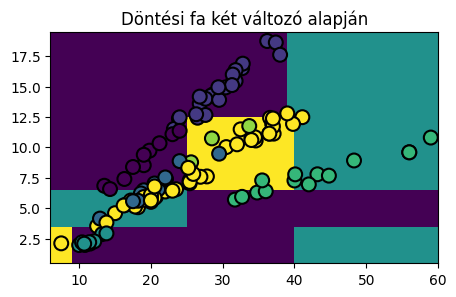

In [6]:
clf_tree_2var = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)

clf_tree_2var.fit(x_train, y_train)

scatter_grid(x_train, y_train, ['Hossz1','Magassag'], clf_tree_2var, 'Döntési fa két változó alapján')

## Kép generálása a modellből és mentés .png-ként

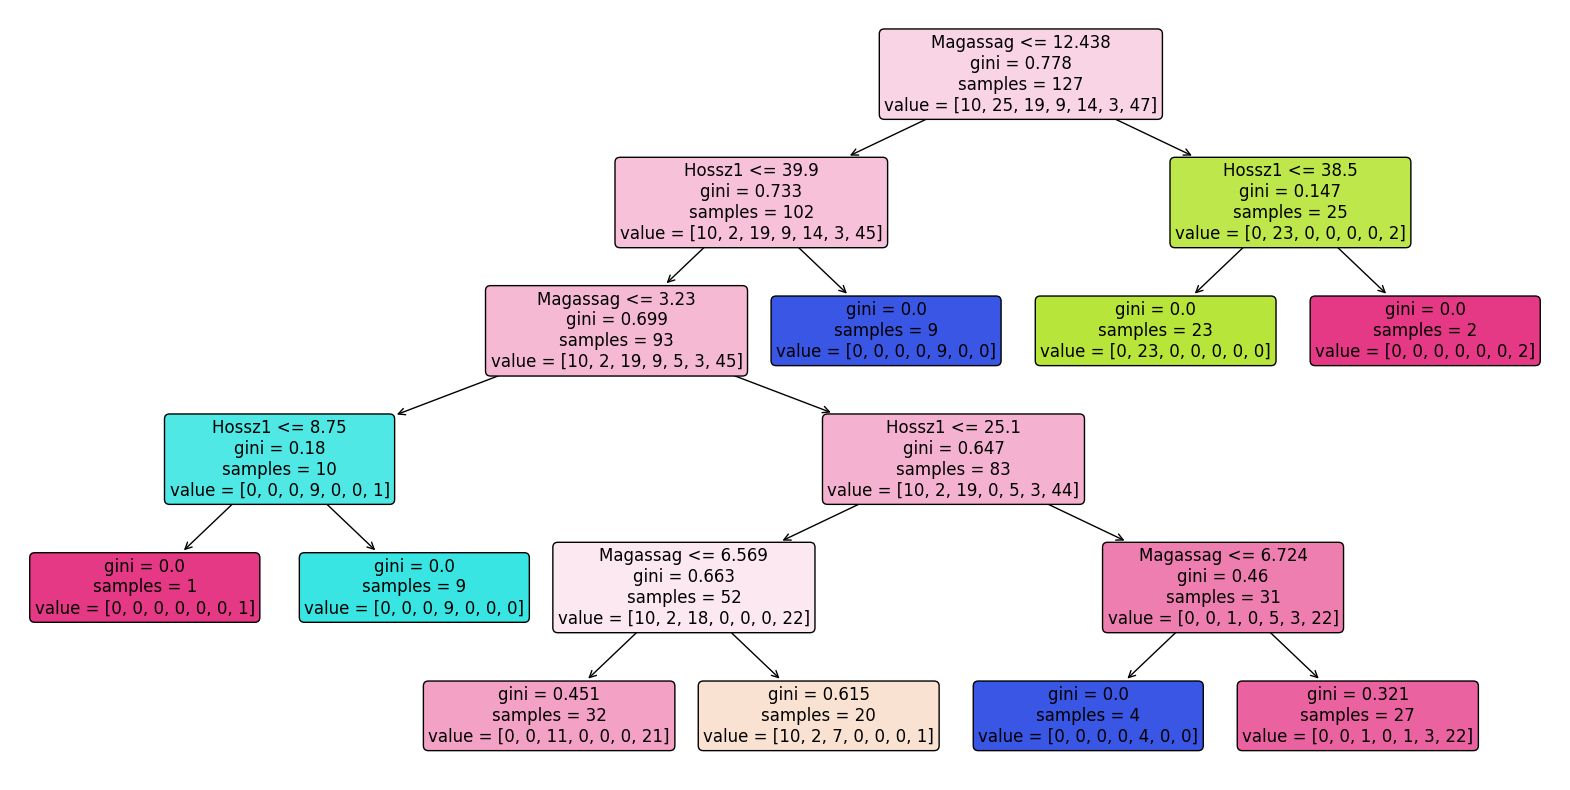

In [7]:
tree_graph_to_png(dtree=clf_tree_2var, feature_names=list(x_train.columns), figs=(20, 10), fonts=12)

## Predikció

In [13]:
y_pred = clf_tree_2var.predict(x_val)

# Egy egyszerű DataFrame a célváltozó értékeinek megtekintésére az egyes kísérletekben
df_pred = pd.DataFrame({
    'original': y_val, 
    'predicted': y_pred
})

df_pred['match'] = [True if x==y else False for x,y in zip(df_pred['original'], df_pred['predicted'])]

print(f"Pontosság: {round(accuracy_score(y_val, y_pred) * 100, 2)}%")
df_pred.reset_index().drop('index', axis=1, inplace=False)

Pontosság: 78.12%


,original,predicted,match
0,Sügér,Sügér,True
1,Bűzöslazac,Bűzöslazac,True
2,Csuka,Csuka,True
3,Maréna,Amur,False
4,Sügér,Sügér,True
5,Aranyosfejű,Aranyosfejű,True
6,Bűzöslazac,Bűzöslazac,True
7,Bodorka,Amur,False
8,Sügér,Amur,False
9,Csuka,Csuka,True


### Mégegy próba, több változóval
Ezúttal próbáljuk meg az összes rendelkezésre álló változót felvenni a predikcióba, és nézzük meg, pontosabb lesz-e!

In [17]:
varlst = ['Suly', 'Hossz1', 'Hossz2', 'Hossz3', 'Magassag', 'Szelesseg']

X = df[varlst] # Független változók
Y = df['Faj'] # Célváltozó

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

clf_tree_multivar = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)

clf_tree_multivar.fit(x_train, y_train)

y_pred_tree = clf_tree_multivar.predict(x_val)

df_pred['tree_pred'] = y_pred_tree

df_pred['tree_match'] = [True if x==y else False for x,y in zip(df_pred['original'], df_pred['tree_pred'])]

print(f"Pontosság: {round(accuracy_score(y_val, y_pred_tree) * 100, 2)}%")


Pontosság: 81.25%


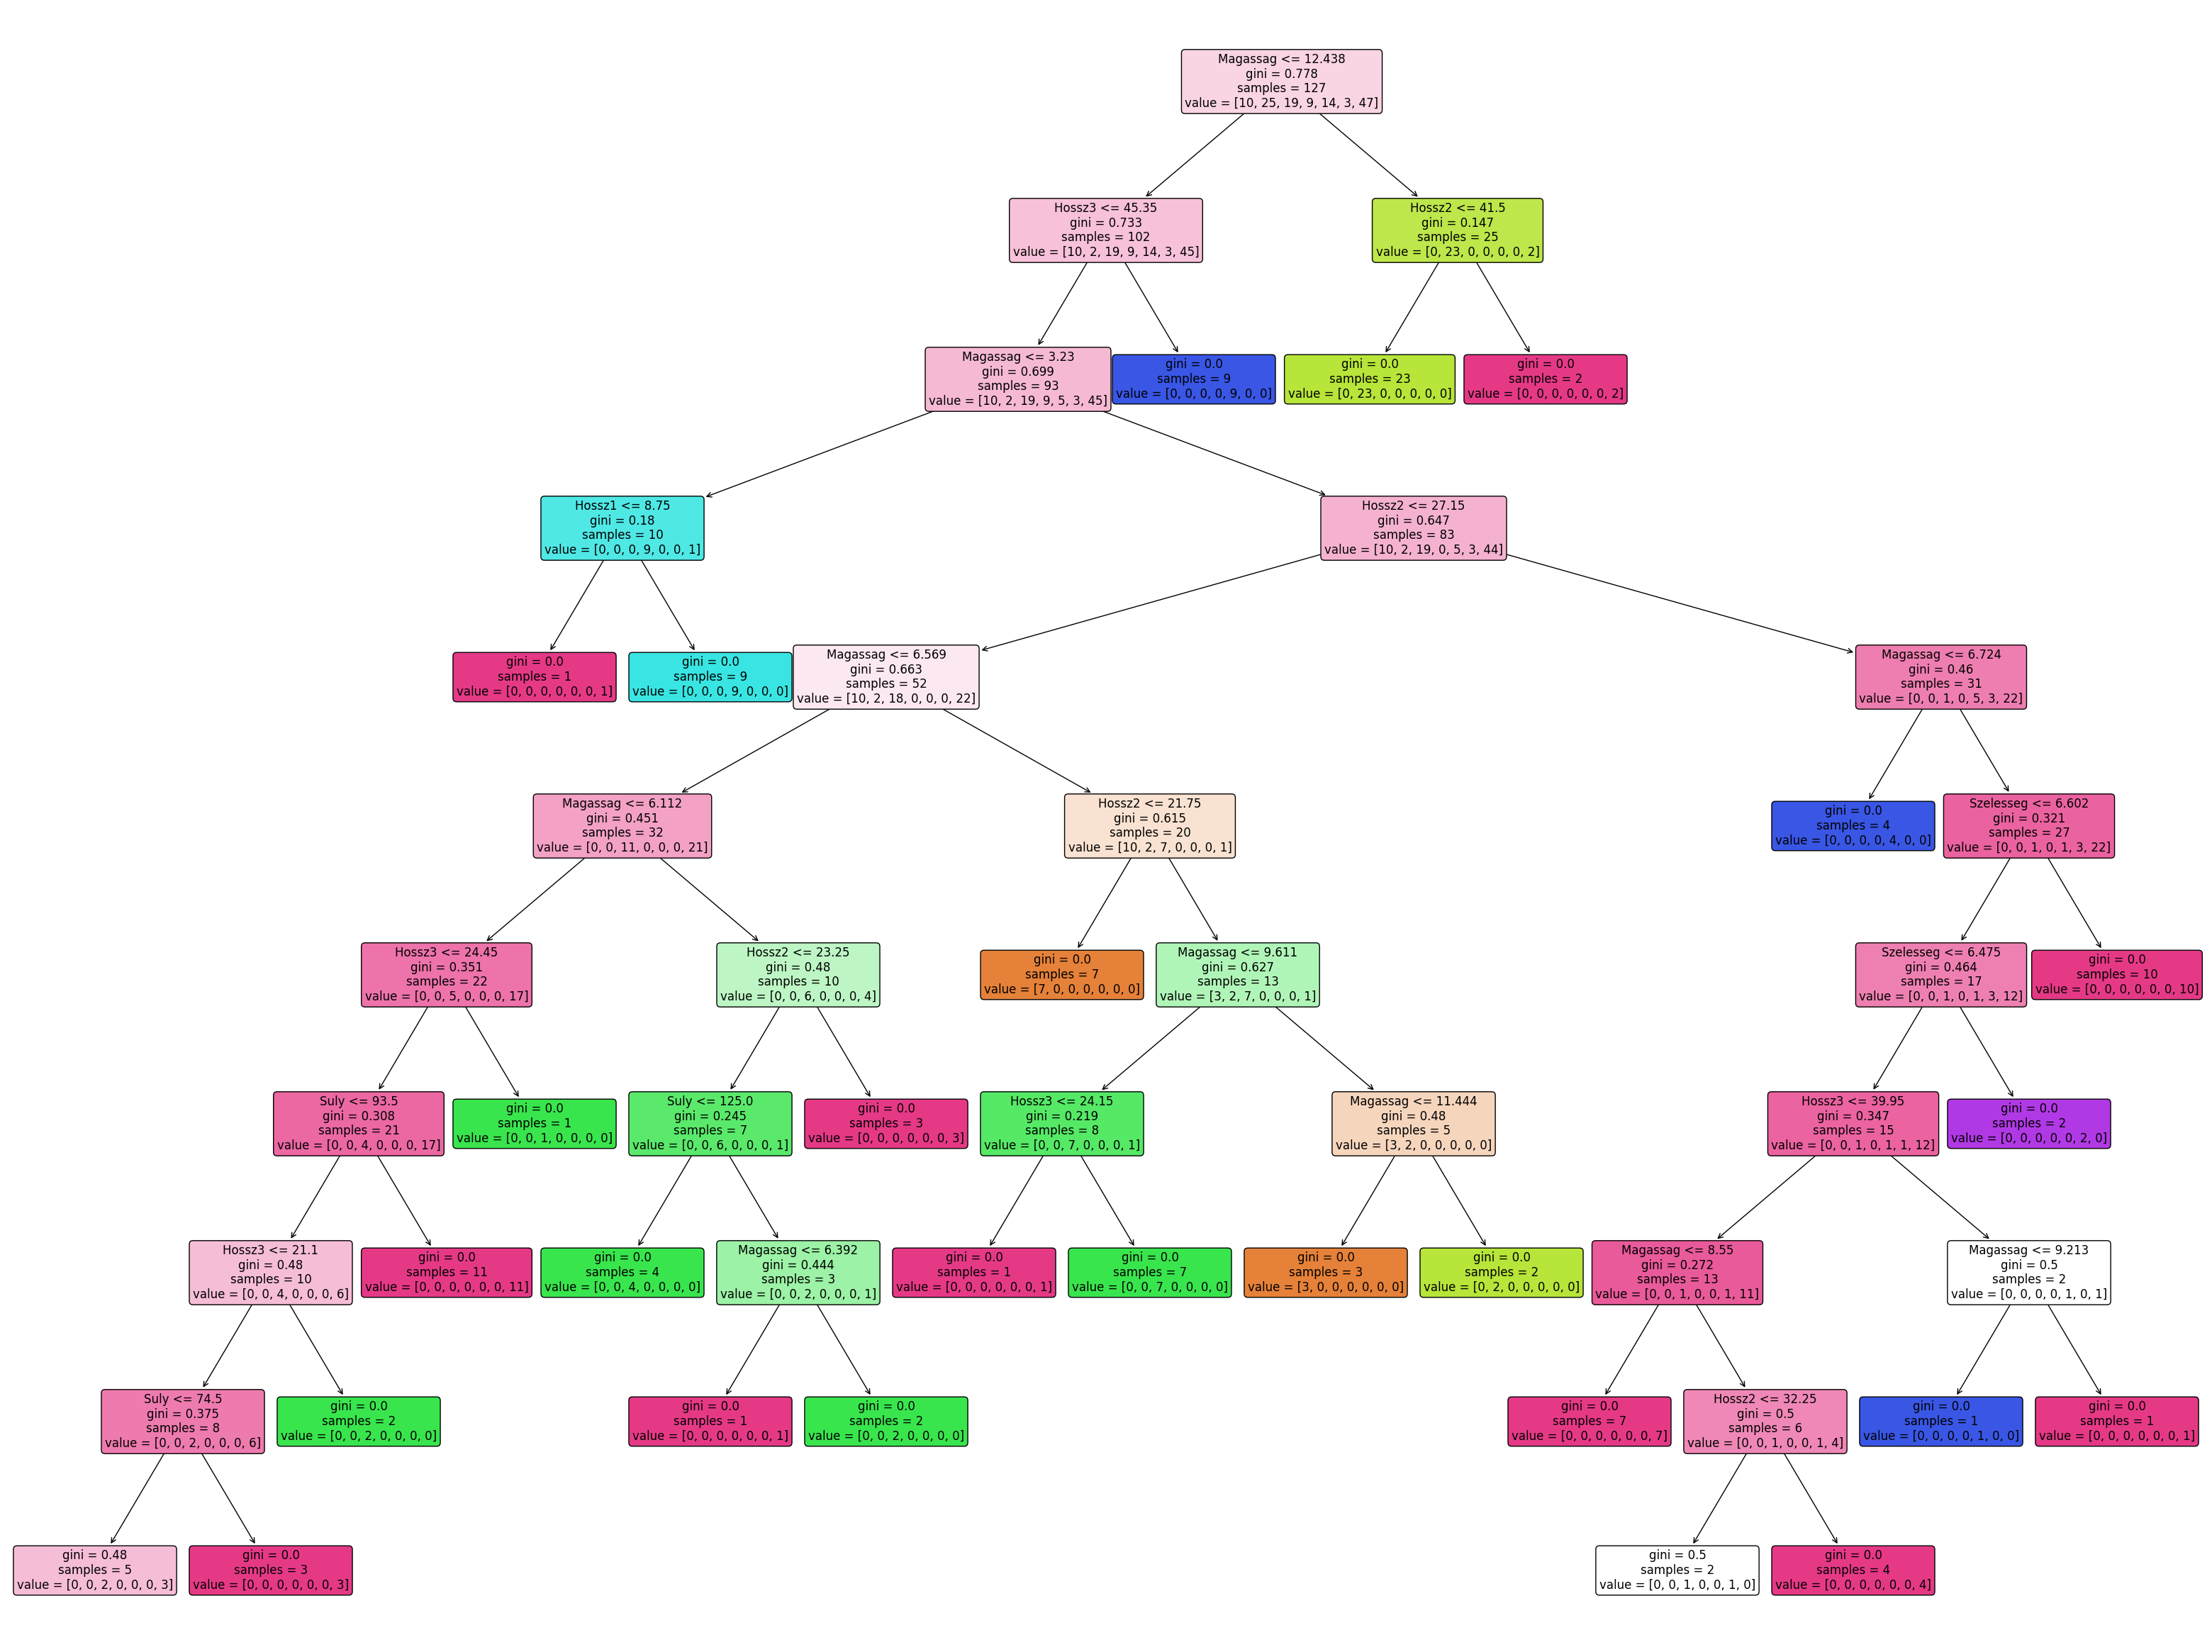

In [18]:
tree_graph_to_png(dtree=clf_tree_multivar, feature_names=varlst, figs=(40,30), fonts=12)

In [19]:
df_pred

,original,predicted,match,tree_pred,tree_match
78,Sügér,Sügér,True,Sügér,True
155,Bűzöslazac,Bűzöslazac,True,Bűzöslazac,True
128,Csuka,Csuka,True,Csuka,True
55,Maréna,Amur,False,Bodorka,False
94,Sügér,Sügér,True,Bodorka,False
29,Aranyosfejű,Aranyosfejű,True,Aranyosfejű,True
147,Bűzöslazac,Bűzöslazac,True,Bűzöslazac,True
51,Bodorka,Amur,False,Bodorka,True
98,Sügér,Amur,False,Bodorka,False
141,Csuka,Csuka,True,Csuka,True
